**For this run, we will try to use automation pmdarima**

**run5 use d=0, D=1, seasonal=True, m = 14**

In [2]:
#import all relevant libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib
import seaborn as sns
import sklearn
from scipy import stats

In [3]:
# import dataset
df = pd.read_csv('PCG.csv', index_col='StartDate',parse_dates=True)
df

,Year,Month,month week,WeekNum,PCG-BP,PCG-EMI,PCG-P09,PCG-P10,PCG-P15,PCG-P20,PCG-P25,PCG-P26,PCG-SS,PCG-SIN,PCG-SGS,PCG-EFB,PCG-P05
StartDate,,,,,,,,,,,,,,,,,
2013-12-30,2013,12,1,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,2014,1,4,2,2.0,0.0,6.0,1.0,46.0,9.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0
2014-01-13,2014,1,4,3,2.0,0.0,6.0,1.0,46.0,10.0,3.0,10.0,1.0,0.0,0.0,0.0,0.0
2014-01-20,2014,1,4,4,2.0,0.0,6.0,1.0,46.0,9.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0
2014-01-27,2014,1,4,5,3.0,0.0,6.0,1.0,46.0,10.0,3.0,10.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,2023,12,4,49,0.0,0.0,0.0,0.0,82.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-11,2023,12,4,50,1.0,0.0,1.0,0.0,82.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-18,2023,12,4,51,0.0,0.0,0.0,0.0,82.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2013-12-30 to 2024-01-01
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        523 non-null    int64  
 1   Month       523 non-null    int64  
 2   month week  523 non-null    int64  
 3   WeekNum     523 non-null    int64  
 4   PCG-BP      521 non-null    float64
 5   PCG-EMI     521 non-null    float64
 6   PCG-P09     521 non-null    float64
 7   PCG-P10     521 non-null    float64
 8   PCG-P15     521 non-null    float64
 9   PCG-P20     521 non-null    float64
 10  PCG-P25     521 non-null    float64
 11  PCG-P26     521 non-null    float64
 12  PCG-SS      521 non-null    float64
 13  PCG-SIN     521 non-null    float64
 14  PCG-SGS     521 non-null    float64
 15  PCG-EFB     521 non-null    float64
 16  PCG-P05     521 non-null    float64
dtypes: float64(13), int64(4)
memory usage: 73.5 KB


In [5]:
#df.index = pd.to_datetime(df.index) # convert to DatetimeIndex
#df.index = df.index.to_period('W-MON') # convert to PeriodIndex with weekly frequency

# convert the index to a range date
df.index = df.index.to_pydatetime()
df.index = df.index.strftime('%Y-%m-%d')

In [6]:
# DATA CLEANING
# drop unrelated column

df = df.drop(df.columns[[0,1,2,3]], axis=1)
df = df.fillna(0)    # fill na cells with 0

# remove first and last row due to their insignificant values
df.drop(df.head(1).index,inplace=True) # drop first row
df.drop(df.tail(1).index,inplace=True) # drop last row

df

,PCG-BP,PCG-EMI,PCG-P09,PCG-P10,PCG-P15,PCG-P20,PCG-P25,PCG-P26,PCG-SS,PCG-SIN,PCG-SGS,PCG-EFB,PCG-P05
2014-01-06,2.0,0.0,6.0,1.0,46.0,9.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0
2014-01-13,2.0,0.0,6.0,1.0,46.0,10.0,3.0,10.0,1.0,0.0,0.0,0.0,0.0
2014-01-20,2.0,0.0,6.0,1.0,46.0,9.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0
2014-01-27,3.0,0.0,6.0,1.0,46.0,10.0,3.0,10.0,1.0,0.0,0.0,0.0,0.0
2014-02-03,0.0,0.0,2.0,0.0,22.0,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,2.0,0.0,1.0,0.0,12.0,6.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0
2023-12-04,0.0,0.0,0.0,0.0,82.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-11,1.0,0.0,1.0,0.0,82.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-18,0.0,0.0,0.0,0.0,82.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df.index

Index(['2014-01-06', '2014-01-13', '2014-01-20', '2014-01-27', '2014-02-03',
       '2014-02-10', '2014-02-17', '2014-02-24', '2014-03-03', '2014-03-10',
       ...
       '2023-10-23', '2023-10-30', '2023-11-06', '2023-11-13', '2023-11-20',
       '2023-11-27', '2023-12-04', '2023-12-11', '2023-12-18', '2023-12-25'],
      dtype='object', length=521)

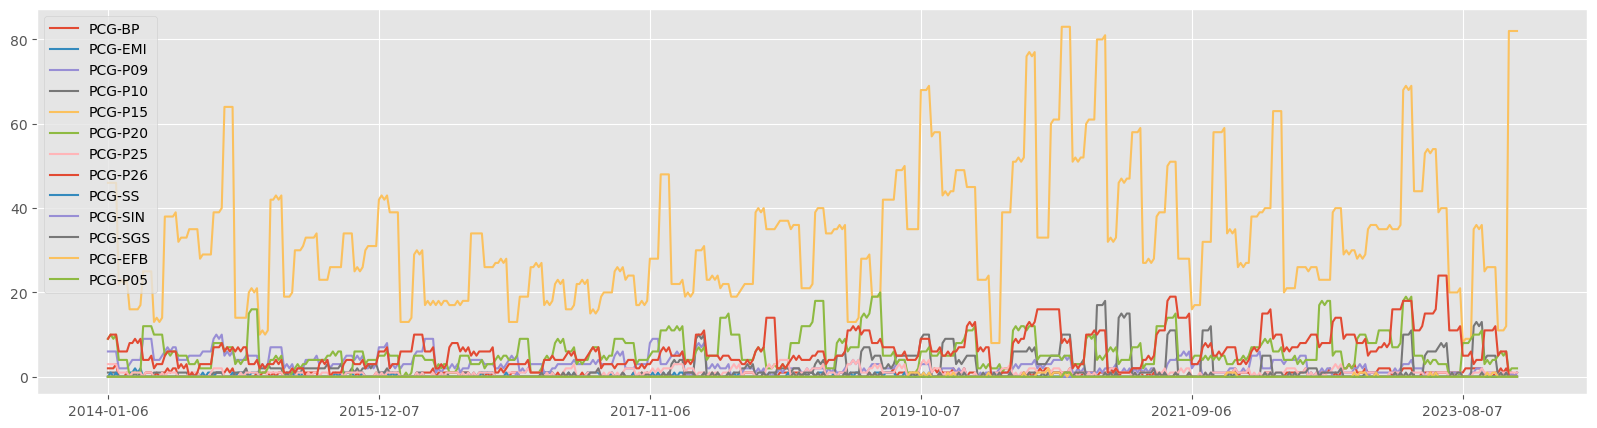

In [8]:
# plot the generaL view

fig, ax1 = plt.subplots(figsize=(20,5))
df.plot(ax=ax1)
plt.show()

**From the above plot, we are focusing on model 'PCG-P15' as our desired model, due to its highest average count**

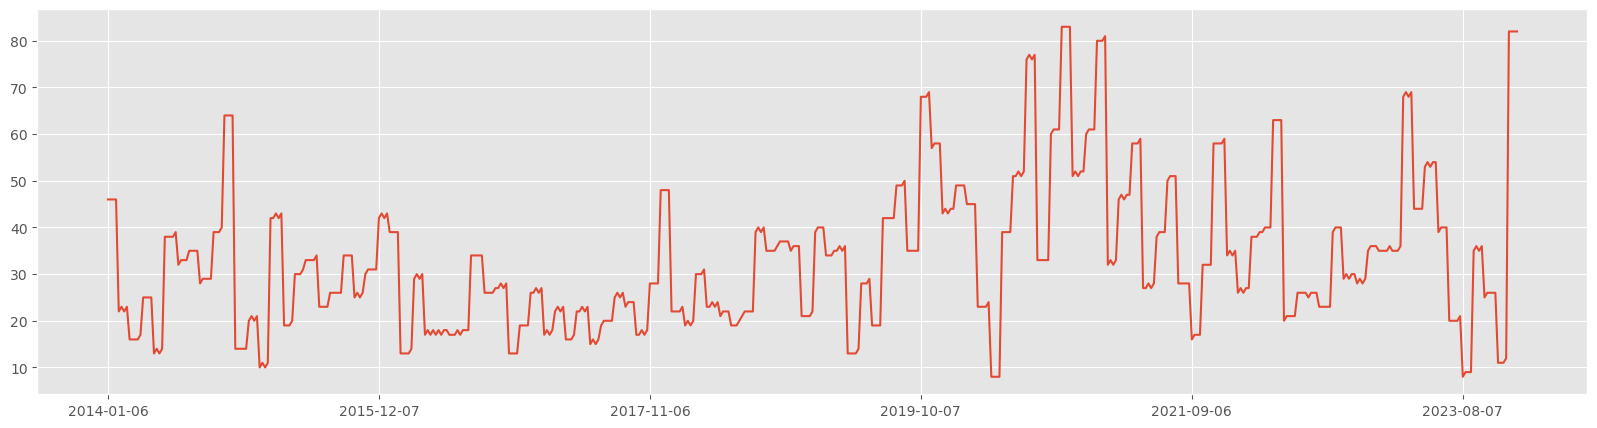

In [9]:
# plot the column 'PCG-P15'

fig, ax1 = plt.subplots(figsize=(20,5))
df['PCG-P15'].plot(ax=ax1)
plt.show()

The 'PCG-P15' plot shows there's no obvious trend and thus is assumed to be stationary.

A few outliers observed from this plot and there's also a possibility of seasonality on a smaller scale for this time-series, which we will further confirmed in the following steps.

In [10]:
# removing outlier using Z-score method for all models

z = np.abs(stats.zscore(df))          # find absolute value of z-score
df_clean = df[(z<3).all(axis=1)]      # only keep rows with z<|3|
df_clean.shape

(438, 13)

In [11]:
df_clean

,PCG-BP,PCG-EMI,PCG-P09,PCG-P10,PCG-P15,PCG-P20,PCG-P25,PCG-P26,PCG-SS,PCG-SIN,PCG-SGS,PCG-EFB,PCG-P05
2014-01-06,2.0,0.0,6.0,1.0,46.0,9.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0
2014-01-20,2.0,0.0,6.0,1.0,46.0,9.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0
2014-02-03,0.0,0.0,2.0,0.0,22.0,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
2014-02-10,0.0,0.0,2.0,0.0,23.0,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
2014-02-17,0.0,0.0,2.0,0.0,22.0,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-16,0.0,0.0,1.0,5.0,26.0,3.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0
2023-11-06,1.0,0.0,0.0,0.0,11.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2023-11-13,2.0,0.0,0.0,0.0,11.0,6.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0
2023-11-20,1.0,0.0,0.0,0.0,11.0,5.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0


After removing the outliers, there's only 438 rows left for the analysis.

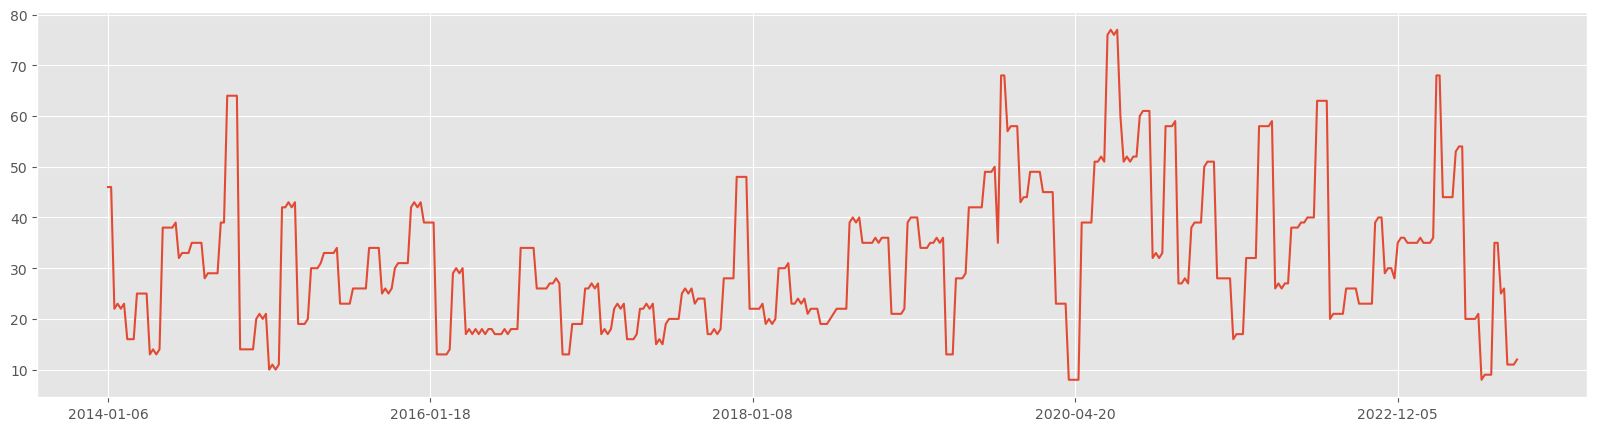

In [12]:
# plot the cleaned 'PCG-P15'

fig, ax1 = plt.subplots(figsize=(20,5))
df_clean['PCG-P15'].plot(ax=ax1)
plt.show()

THE BOX-JENKINS METHOD
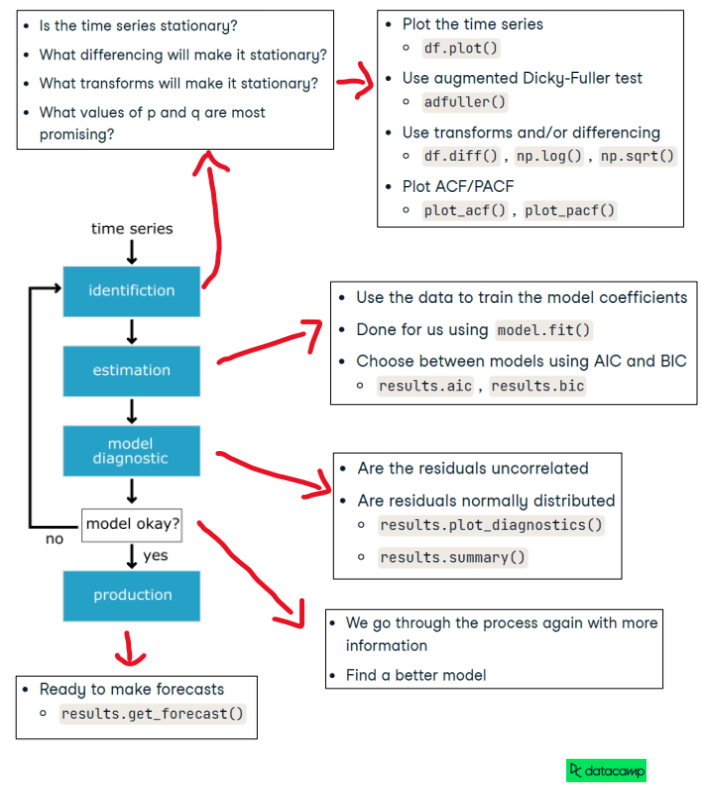

**STEP 1: IDENTIFICATION**

1.1) Test for stationarity

In [13]:
# assign the cleaned selected column 'PCG-P15' into new variable
P15 = df_clean["PCG-P15"]
P15

2014-01-06    46.0
2014-01-20    46.0
2014-02-03    22.0
2014-02-10    23.0
2014-02-17    22.0
              ... 
2023-10-16    26.0
2023-11-06    11.0
2023-11-13    11.0
2023-11-20    11.0
2023-11-27    12.0
Name: PCG-P15, Length: 438, dtype: float64

In [14]:
# identify if the time-series is stationary by using Augmented Dickey-Fuller test (ADFT)
# null hypothesis: time-series is non-stationary (p > 0.05)

result_ADF = adfuller(P15)
print(result_ADF)
print('p-value is: ',result_ADF[1])

(-3.1787358143103077, 0.021249001862636688, 18, 419, {'1%': -3.4460536145702383, '5%': -2.868462751982839, '10%': -2.570457599182051}, 2901.681896453503)
p-value is:  0.021249001862636688


Since the p < 0.05, we have to reject the null hypothesis (reject non-stationary).
Thus, our time-series is stationary and no further transformation or differencing is needed (d = 0).

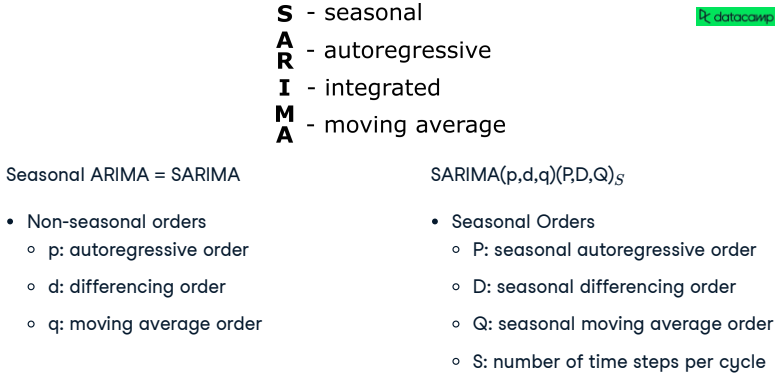

1.2) Seasonal decomposition of the time-series

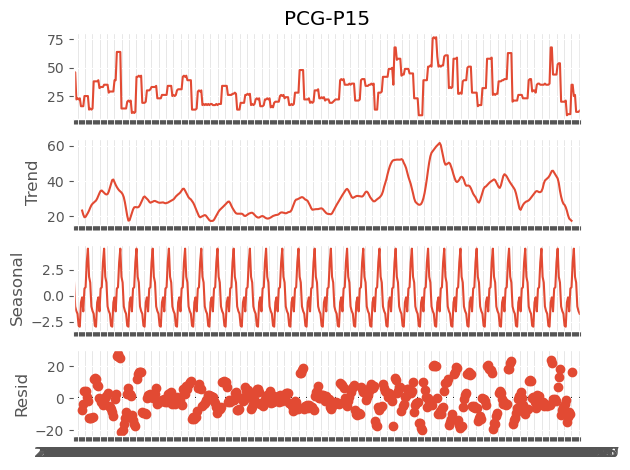

In [17]:
# plot the decomposition of seasonal behavior for the time-series

from statsmodels.tsa.seasonal import seasonal_decompose

decomp_results = seasonal_decompose(P15, period = 14)

# Plot decomposed data
decomp_results.plot()
plt.show()

1.3) Identifying seasonal data using ACF

Despite no obvious trend from the above plot, the seasonal plot however indicates there's exist a seasonal behavior for this time-series.

To confirm this, we are using AutoCorrelation Function (ACF) in order to detect the season cycle.

In [16]:
P15_seasonal = P15 - P15.rolling(4).mean()    # subtract long rolling average over 5 steps
P15_seasonal = P15_seasonal.dropna()          # drop NaN values
P15_seasonal

2014-02-10   -11.25
2014-02-17    -6.25
2014-02-24     0.50
2014-03-03    -5.00
2014-03-10    -3.25
              ...  
2023-10-16    -4.25
2023-11-06   -13.25
2023-11-13    -7.25
2023-11-20    -3.75
2023-11-27     0.75
Name: PCG-P15, Length: 435, dtype: float64

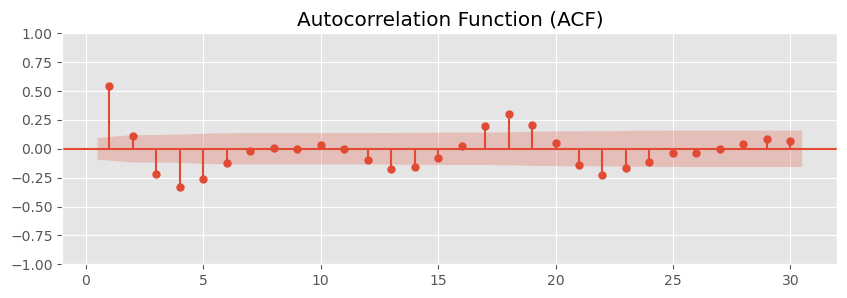

In [16]:
# import ACF/PACF library
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,1, figsize=(10,3))

# Plot ACF
plot_acf(P15_seasonal, ax=ax, lags = 30, title='Autocorrelation Function (ACF)', zero=False)
plt.show()

Although the earlier plot of 'PCG-P15' did not show obvious seasonal behavior, its ACF plot however shows a periodic correlaction pattern at 14 interval

Hence, we will use SARIMA model instead of ARIMA model for this time-series due to its seasonality pattern.

**STEP 2: ESTIMATION**

  2.1) Train the model coefficients using model.fit()

In [ ]:
# use automation pmdarima to look for non-seasonal and seasonal time-series order

import pmdarima as pm
auto = pm.auto_arima(P15, d=0,       # the non-seasonality is already stationary
                     start_p=1,
                     start_q=1,
                     max_p=6,
                     max_q=6,
                     seasonal=True,
                     m=14,                # the seasonality cycle is at every 14
                     D=2,                 # seasonality differencing
                     start_P=1,
                     start_Q=1,
                     max_P=6,
                     max_Q=6,
                     information_criterion='aic',
                     trace=True,
                     error_action='ignore',
                     stepwise=True)

print(auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,2,1)[14]             : AIC=inf, Time=5.10 sec
 ARIMA(0,2,0)(0,2,0)[14]             : AIC=3888.457, Time=0.11 sec
 ARIMA(1,2,0)(1,2,0)[14]             : AIC=3544.316, Time=0.56 sec
 ARIMA(0,2,1)(0,2,1)[14]             : AIC=inf, Time=4.83 sec
 ARIMA(1,2,0)(0,2,0)[14]             : AIC=3774.971, Time=0.31 sec
 ARIMA(1,2,0)(2,2,0)[14]             : AIC=3450.721, Time=1.53 sec
 ARIMA(1,2,0)(3,2,0)[14]             : AIC=3406.592, Time=3.28 sec
 ARIMA(1,2,0)(4,2,0)[14]             : AIC=3348.894, Time=6.91 sec
 ARIMA(1,2,0)(5,2,0)[14]             : AIC=3308.475, Time=19.23 sec
 ARIMA(1,2,0)(5,2,1)[14]             : AIC=inf, Time=76.66 sec
 ARIMA(1,2,0)(4,2,1)[14]             : AIC=inf, Time=43.90 sec
 ARIMA(0,2,0)(5,2,0)[14]             : AIC=3416.395, Time=9.44 sec
 ARIMA(2,2,0)(5,2,0)[14]             : AIC=3267.192, Time=22.11 sec
 ARIMA(2,2,0)(4,2,0)[14]             : AIC=3311.195, Time=8.98 sec
 ARIMA(2,2,0)(5,2,1)[14]           

**STEP 3: MODEL DIAGNOSTIC**

  3.1) Checking for the residual correlation

Prob(Q): p > 0.05, thus we have to cannot reject the null hypothesis (residuals are uncorrelated white Gaussian noise)

Prob(JB): p < 0.05, thus we have to reject the null hypothesis (the residual is not normally distributed)

In [ ]:
auto.plot_diagnostics(figsize=(10,8))

**STEP 4: PRODUCTION**

**Train & Test Model**

In [ ]:
# We chose order of ARIMA(2,0,0)(5,1,0)[14] from pmdarima automation selection above
model = sm.tsa.arima.ARIMA(P15, order=(2,0,0), seasonal_order=(5,1,0,14))
bestfit = model.fit()
print(bestfit.summary())

In [ ]:
pred_train = bestfit.get_prediction(start=15,dynamic=False)
pred_train_ci = pred_train.conf_int()
ax = P15.plot(label='observed')
pred_train.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.8, figsize=(20, 5))
ax.fill_between(pred_train_ci.index,
                pred_train_ci.iloc[:, 0],
                pred_train_ci.iloc[:, 1], color='r', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('PCG-P15 Sales Order Unit')
plt.legend()
plt.show()

**Producing and Visualizing Forecast**

In [ ]:
fore_test = bestfit.get_forecast(steps = 50)
fore_test_ci = fore_test.conf_int()
ax = P15.plot(label='observed')
fore_test.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.8, figsize=(20, 5))
ax.fill_between(fore_test_ci.index,
                fore_test_ci.iloc[:, 0],
                fore_test_ci.iloc[:, 1], color='r', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('PCG-P15 Sales Order Unit')
plt.legend()
plt.show()



#pred_uc = results.get_forecast(steps=100)
#pred_ci = pred_uc.conf_int()
#ax = y.plot(label='observed', figsize=(14, 7))
#pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
#ax.fill_between(pred_ci.index,
                #pred_ci.iloc[:, 0],
                #pred_ci.iloc[:, 1], color='k', alpha=.25)
#ax.set_xlabel('Date')
#ax.set_ylabel('Furniture Sales')
#plt.legend()
#plt.show()

In [ ]:
#lookin at our residual
residuals = bestfit.resid
residuals

In [ ]:
# how far our prediction from the real valuess
mae = np.mean(np.abs(residuals)) # Mean Absolute Error
print('Mean Absolute Error (MAE) : ' + str(round(mae,3)))

In [ ]:
# calculate Mean-Squared Error (MSE) of the forecast

P15_forecasted = pred_train.predicted_mean
P15_truth = P15['2014-01-06':]
mse = ((P15_forecasted - P15_truth) ** 2).mean()
print('Mean Squared Error (MSE) : ' + str(round(mse, 3)))

In [ ]:
print('Root Mean Squared Error (RMSE) : ' + str(round(np.sqrt(mse), 3)))

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 8.371 of the real sales. Our weekly Sales Order unit range from around 0 to 80 unit.